# Chapter.5 Multi-Variate Linear Regression

## Programming Assignment.5-06 MVLR for several samples
PA 5_06에서는 data sample을 여러개 사용하는 mini-batch를 이용하여<br>
PA 5_05에서 학습했던 N차원의 input에 대한 Learning하는 방법을 할 것입니다<br><br>
진행과정은 다음과 같습니다<br><br>
1.Data Sample Generation<br>
2.Mini-batch Preparation<br>
3.Basic node <br>
4.Hyperparameter<br>
5.Learning with mini-batch<br>
6.Visualization<br>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import basic_nodes as nodes
import os
import sys
utils_path = os.path.dirname(os.path.abspath(__name__)) + '/../utils/'
if utils_path not in sys.path:    
    sys.path.append(utils_path)


from LR_dataset_generator import LR_dataset_generator
    
plt.style.use('seaborn')
np.random.seed(0)

def get_data_batch(dataset, batch_idx, batch_size, n_batch):
    if batch_idx is n_batch -1:
        batch = dataset[batch_idx*batch_size:]
    else:
        batch = dataset[batch_idx*batch_size : (batch_idx+1)*batch_size]
    return batch

### 1.Data Sample Generation
$\hat{y} = \theta_{3}x_{3} + \theta_{2}x_{2} + \theta_{1}x_{1} + \theta_{0}$<br> 위와 같은 모델을 사용하며<br><br>
$y = x_{3} + 4x_{2} + 2x_{1}  + 5$<br> Data Sample은 위의 식을 통해서 생성합니다<br>
mean은 0 std은 1로 설정합니다

In [3]:
##### Start Your Code(Dataset Setting) #####
coefficient_list = [5, 2, 4, 1]
distribution_params = {1:{'mean':0, 'std':1},
                       2:{'mean':0, 'std':1},
                       3:{'mean':0, 'std':1}
                       }
##### End Your Code(Dataset Setting) #####


##### Start Your Code(Dataset Generation) #####
data_gen = LR_dataset_generator(feature_dim = 3)
data_gen.set_coefficient(coefficient_list)
data_gen.set_distribution_params(distribution_params)


##### End Your Code(Dataset Generation) #####
x_data, y_data = data_gen.make_dataset()
dataset = np.hstack((x_data,y_data))

In [6]:
x_data[1]

array([ 0.        ,  0.40015721, -1.34775906, -0.23937918])

### 2.Mini-batch Preparation
mini-batch에 관련된 변수들을 설정합니다
* batch_size 8
* batch_idx  0


In [4]:
### Start code
feature_dim = 3
batch_size = 8
batch_idx = 0
### End code
n_batch = int(np.ceil(dataset.shape[0]/batch_size))

batch = get_data_batch(dataset, batch_idx,batch_size, n_batch)
print("batch.shape : ", batch.shape)
X, Y = batch[:,:-1], batch[:,-1]
print("X.shape : ", X.shape)
print("Y.shape : ", Y.shape, '\n')

batch.shape :  (8, 5)
X.shape :  (8, 4)
Y.shape :  (8,) 



In [19]:
X[:, 1].shape

(8,)

**Expected Output**  
batch.shape : (8, 5)<br>
X.shape : (8, 4)<br>
Y.shape : (8,)

### 3. Basic node 
다음은 필요한 Node 들을 선언합니다<br>
PA 5_05까지와는 달리 mini-batch방식으로 진행하기 때문에<br>
mean_node가 추가로 필요합니다

In [9]:
node1 = [None] + [nodes.mul_node() for _ in range(feature_dim)]
node2 = [None] + [nodes.plus_node() for _ in range(feature_dim)]
node3 = nodes.minus_node()
node4 = nodes.square_node()
node5 = nodes.mean_node()

### 4.Hyperparameter
Hyperparameter들을 설정해줍니다
* Learning Rate 0.01
* epochs 30
* $\theta_{3}, \theta_{2}, \theta_{1}, \theta_{0}$ 초기값    =     0.1  0.1  0.1  0.1

In [11]:
X[1]

array([ 0.        ,  0.40015721, -1.34775906, -0.23937918])

In [13]:
##### Start Your Code(Learning Preparation) #####
lr = 0.01
epochs = 30
Th_list = [ 0.1, 0.1, 0.1, 0.1]

##### End Your Code(Learning Preparation) #####

th_accum = np.array(Th_list).reshape(-1, 1)
cost_list = []

### 5.Learning with mini-batch
PA 5_05에서 진행했던 N차원 input에 대한 Learning을<br>
mini-batch방식으로 진행할 것이다<br>

In [14]:
node1 = [None] + [nodes.mul_node() for _ in range(feature_dim)]
node2 = [None] + [nodes.plus_node() for _ in range(feature_dim)]
node3 = nodes.minus_node()
node4 = nodes.square_node()
node5 = nodes.mean_node()

In [23]:
for epoch in range(epochs):
    np.random.shuffle(dataset)
    for batch_idx in range(n_batch):
        ##### Start Your Code(Batch Extraction) #####
        batch = get_data_batch(dataset, batch_idx, batch_size, n_batch)
        X, Y = batch[:,:-1], batch[:,-1]
        
        #Forward Propagation start
        Z1_list = [None] * (feature_dim + 1)
        Z2_list = Z1_list.copy()
        dZ1_list, dZ2_list = Z1_list.copy(), Z1_list.copy()
        dTh_list = dZ1_list.copy()
        for node_idx in range(1, feature_dim + 1):
            Z1_list[node_idx] = node1[node_idx].forward(Th_list[node_idx], X[:,node_idx]) 
        
        Z2_list[1] = node2[1].forward(Th_list[0], Z1_list[1])
        for node_idx in range(2, feature_dim + 1):
            Z2_list[node_idx] = node2[node_idx].forward(Z2_list[node_idx - 1],Z1_list[node_idx])
        Z3 = node3.forward(Y, Z2_list[-1])
        Z4 = node4.forward(Z3)
        J = node5.forward(Z4)
        #Forward Propagation end
        
        #Backward Propagation start
        dZ4 = node5.backward(1)
        dZ3 = node4.backward(dZ4)
        _, dZ2_last = node3.backward(dZ3)
        dZ2_list[-1] = dZ2_last
        
        for node_idx in reversed(range(1, feature_dim + 1)):
            dZ2, dZ1 = node2[node_idx].backward(dZ2_list[node_idx])
            dZ2_list[node_idx - 1] = dZ2
            dZ1_list[node_idx] = dZ1
        
        dTh_list[0] = dZ2_list[0]
        for node_idx in reversed(range(1, feature_dim + 1)):
            dTh, _ = node1[node_idx].backward(dZ1_list[node_idx])
            dTh_list[node_idx] = dTh
        #Backward Propagation end
        

        for th_idx in range(len(Th_list)):
            Th_list[th_idx] = Th_list[th_idx] - lr*np.sum(dTh_list[th_idx])
        th_next = np.array(Th_list).reshape(-1, 1)
        th_accum = np.hstack((th_accum, th_next))
        cost_list.append(J)

### 6.Visualization

Text(0.5, 1.0, 'Cost')

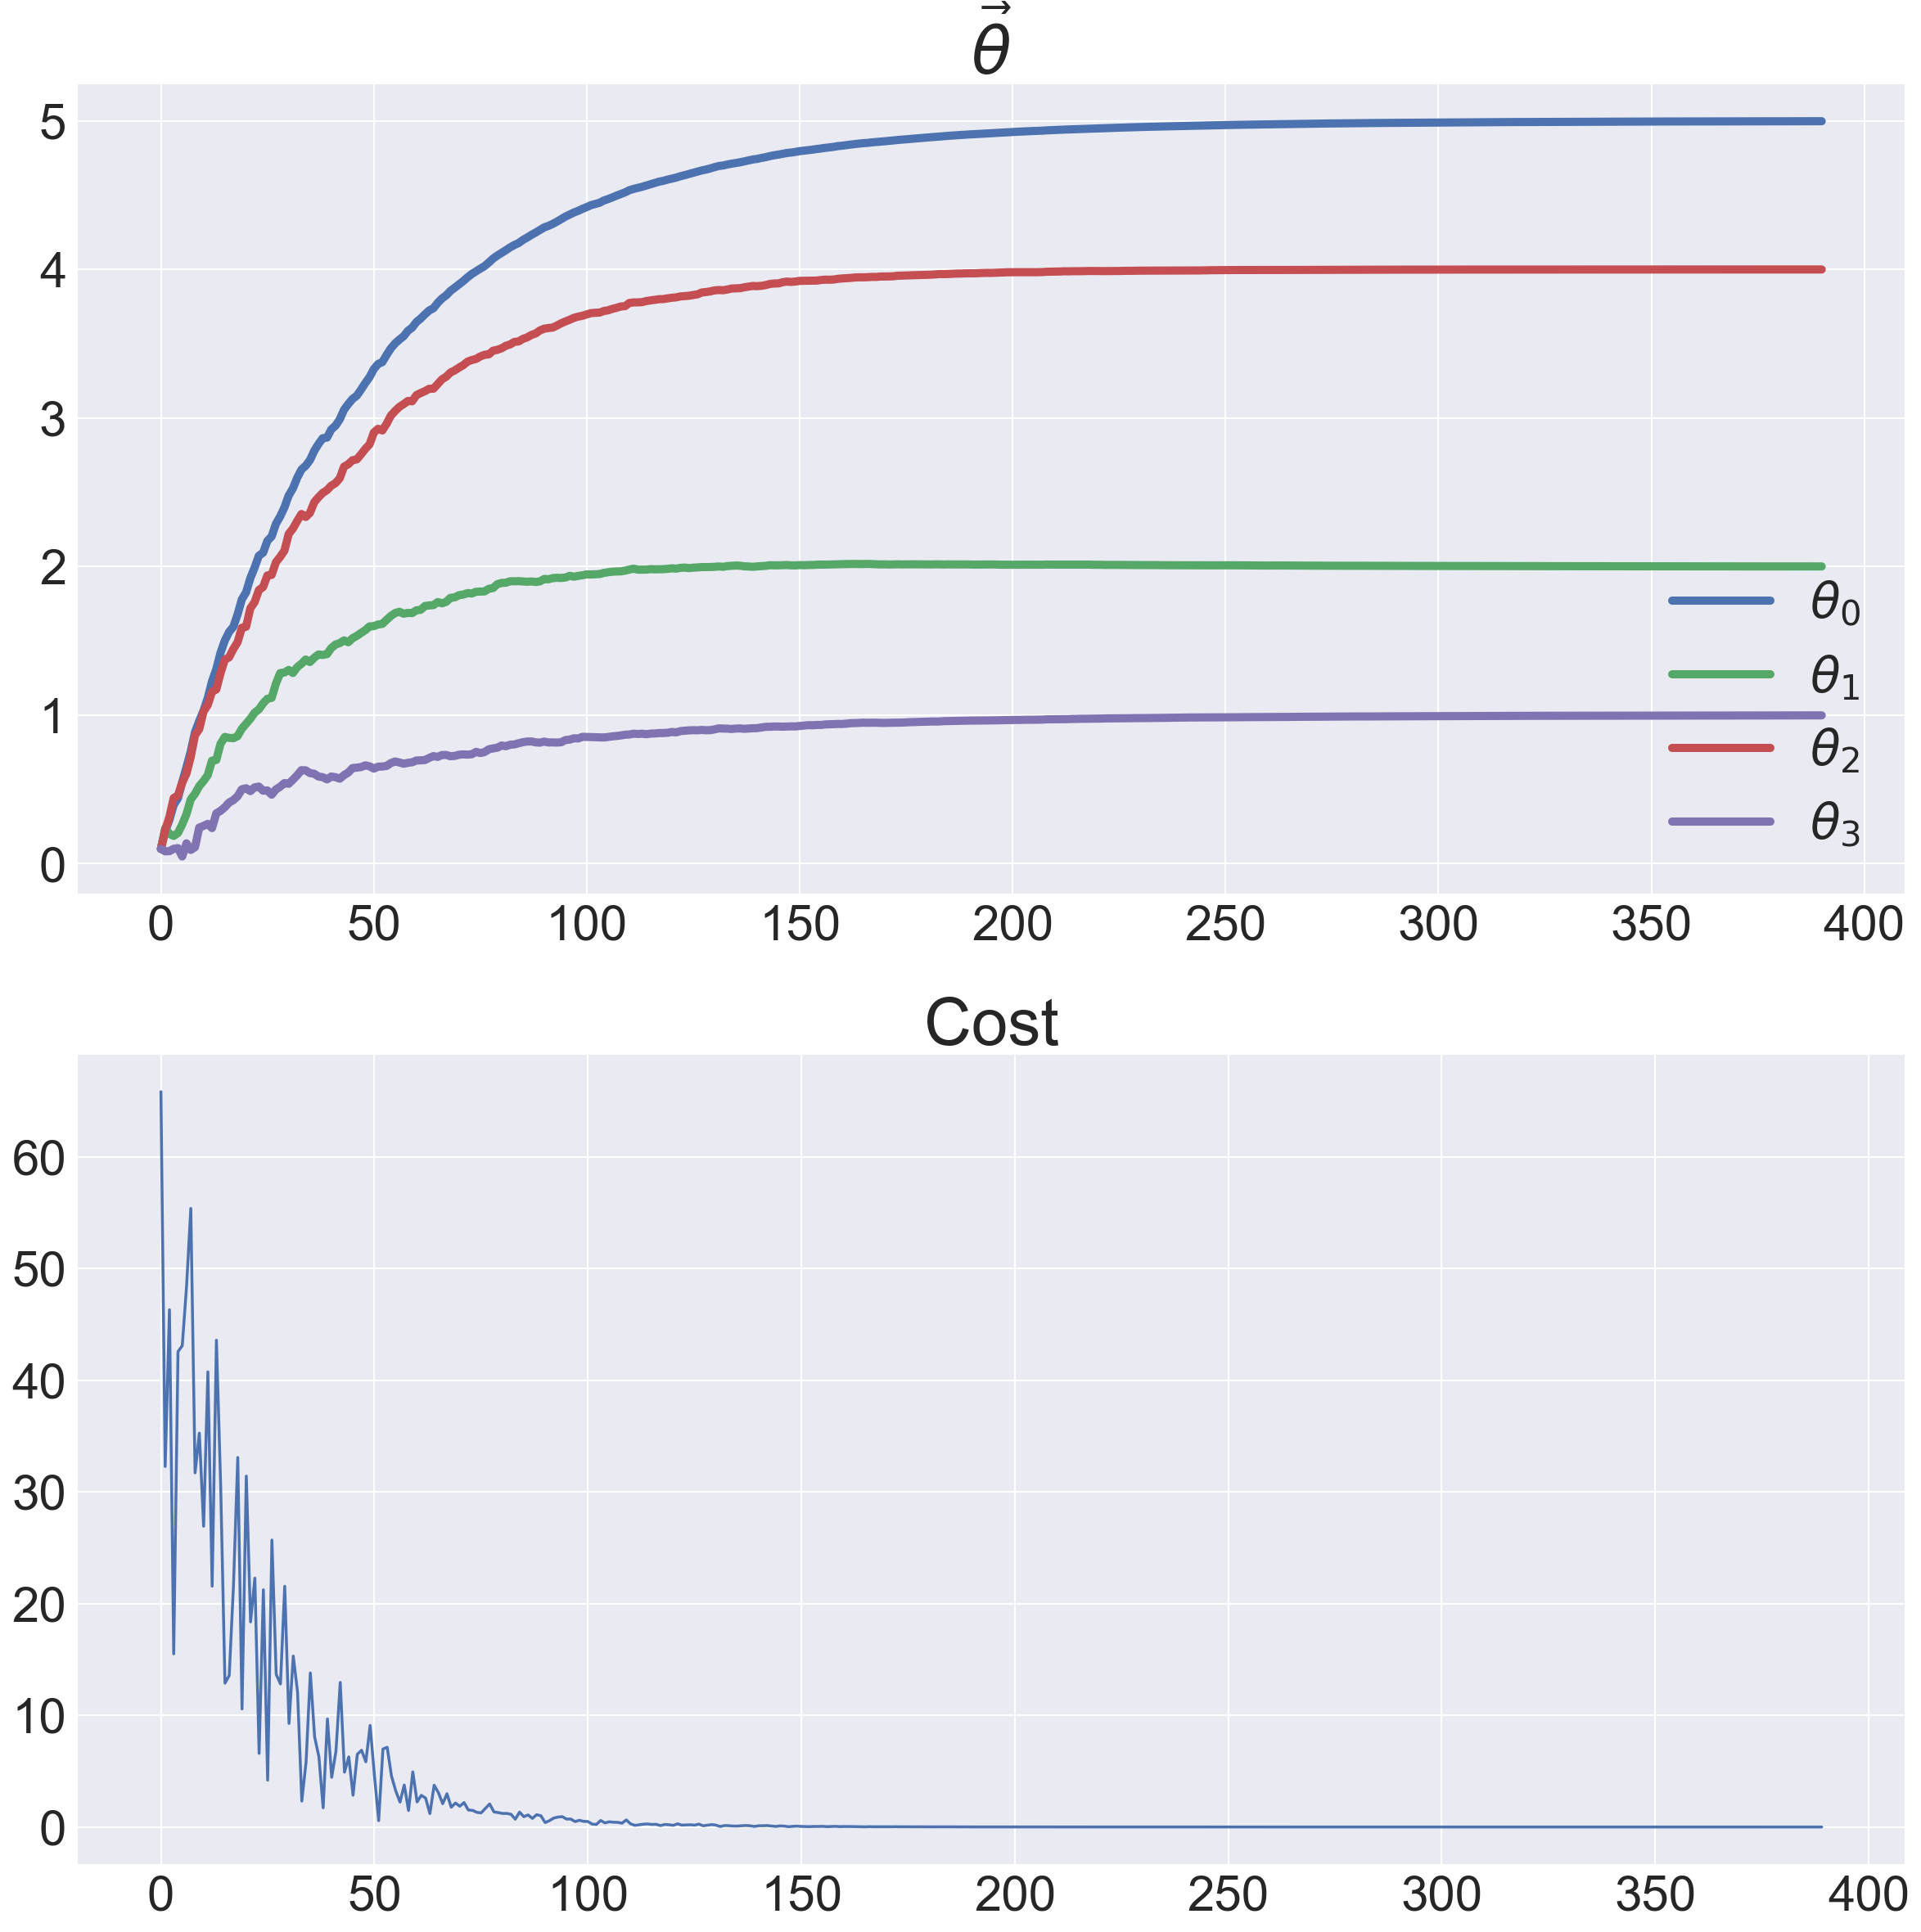

In [24]:
fig, ax = plt.subplots(2, 1, figsize = (20, 20))

for i in range(feature_dim + 1):
    ax[0].plot(th_accum[i], label = r'$\theta_{%d}$'%i,
               linewidth = 5)
ax[1].plot(cost_list)
ax[0].legend(loc = 'lower right',
            fontsize = 30)
ax[0].tick_params(axis = 'both', labelsize = 30)
ax[1].tick_params(axis = 'both', labelsize = 30)

ax[0].set_title(r'$\vec{\theta}$', fontsize = 40)
ax[1].set_title('Cost', fontsize = 40)

**Expected Output**  
<img src='./imgs/5_06_1.png' width = 800>